In [1]:
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../modules/')
from Agents.RepresentationLearning import PlaceCells
from Agents import DQ_agent

In [2]:
def one_hot_state(state):
    vec = np.zeros(env.nstates)
    vec[state] = 1
    return vec

def onehot_state_collection(env):
    collection = []
    for state in range(env.nstates):
        vec = one_hot_state(state)
        collection.append(vec)
    return collection

def twoD_states(env):
    twods = []
    for state in range(env.nstates):
        twod = env.oneD2twoD(state)
        twods.append(twod)
    return twods

def plot_some_place_fields(env, list_of_coords, place_cells):
    states = np.asarray(list_of_coords)
    gridworld_pc_reps = place_cells.get_activities(list_of_coords)

    num_pc_view = 9
    get_rand_cells = np.random.choice(env.nstates,num_pc_view,replace=False)

    fig, axes = plt.subplots(3,3)

    for i, ax in enumerate(axes.flat):
        # for every state, get what the place cell activity is
        ax.scatter(states[:,0],states[:,1], c =gridworld_pc_reps[:,get_rand_cells[i]])
        cell_center = np.round(np.multiply(place_cells.cell_centres[get_rand_cells[i]],env.shape),1)
        print(cell_center)
        ax.set_title(f'{cell_center}')
        ax.set_yticks([])
        ax.set_xticks([])
    plt.show()


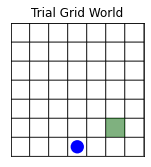

In [14]:
env = gym.make('gym_grid:gridworld-v111')

In [15]:
# get onehot activity vectors 
gridworld_onehots = onehot_state_collection(env)

# get place cell activity vectors 
# make a collection of place cells
place_cells       = PlaceCells(env.shape,env.nstates, field_size=1/env.shape[0])

two_d_states = twoD_states(env) # get all states as coords
# get activities for each state
gridworld_pc_reps = place_cells.get_activities(two_d_states)

State Reps for state 25:(3, 4)


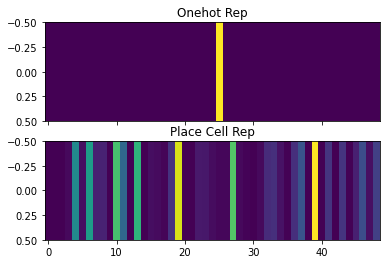

In [16]:
# print onehot activity vector and place cell activity vector for a given state
test_state = 25
print(f'State Reps for state {test_state}:{two_d_states[test_state]}')
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].imshow([gridworld_onehots[test_state]])
ax[0].set_aspect('auto')
ax[0].set_title('Onehot Rep')
ax[1].imshow([gridworld_pc_reps[test_state]])
ax[1].set_aspect('auto')
ax[1].set_title('Place Cell Rep')

plt.show()

In [ ]:
# set up agent parameters
INPUT_DIMS = [env.nstates]
N_ACTIONS  = env.action_space.n
BATCH_SIZE = 64
GAMMA      = 0.98
EPSILON    = 1.0
LR         = 0.01

onehot_agent = DQ_agent(gamma=GAMMA, epsilon=EPSILON, lr=LR,
                       input_dims=INPUT_DIMS, batch_size=BATCH_SIZE,
                       n_actions=N_ACTIONS)
placecell_agent = DQ_agent(gamma=GAMMA, epsilon=EPSILON, lr=LR,
                       input_dims=INPUT_DIMS, batch_size=BATCH_SIZE,
                       n_actions=N_ACTIONS)

In [ ]:
def run_expt(ntrials, nsteps, obs_container, agent):
    scores, eps_history = [],[]
    for trial in range(ntrials):
        score = 0 
        done  = False
        state_id = env.reset()
        observation = obs_container[state_id]
        
        for step in range(nsteps):
            action = agent.choose_action([observation])
            state_id, reward, done, info = env.step(action)
            observation_ = obs_container[state_id]
            score += reward
            agent.store_transition(observation,action,reward,observation_,done)
            agent.learn()
            observation = observation_
            if done:
                break
        scores.append(score)
        eps_history.append(agent.epsilon)
        
        avg_score = np.mean(scores[-100:])
        if trial%20==0:
            print(f'episode:{trial}, score: {score}, avg:{ avg_score}, epsilon: {agent.epsilon}')
    return scores, eps_history

In [ ]:
env1 = gym.make('LunarLander-v2')
print(type(env1.reset()))
print(type(gridworld_onehots[env.reset()]))

In [ ]:
Lunar_agent = DQ_agent(gamma=GAMMA, epsilon=EPSILON, lr=LR,
                       input_dims=[8], batch_size=BATCH_SIZE,
                       n_actions=N_ACTIONS)

In [ ]:
test_batch = torch.tensor([env1.reset()])
testqvals = Lunar_agent.Q_eval(test_batch)

In [ ]:
test_batch = torch.Tensor([gridworld_onehots[env.reset()]])
testqvals = onehot_agent.Q_eval(test_batch)
print(testqvals)
action = onehot_agent.choose_action(test_batch)
print(action)

In [40]:
num_trials = 2000
num_steps = 400
scores, epsilons = run_expt(num_trials, num_steps, gridworld_onehots, onehot_agent)

episode:0, score: -3.9999999999999587, avg:-3.9999999999999587, epsilon: 0.01
episode:20, score: -3.9999999999999587, avg:-2.669047619047581, epsilon: 0.01
episode:40, score: -3.9999999999999587, avg:-2.4302439024389875, epsilon: 0.01
episode:60, score: -3.9999999999999587, avg:-2.716065573770455, epsilon: 0.01
episode:80, score: -3.9999999999999587, avg:-2.5455555555555183, epsilon: 0.01
episode:100, score: -3.9999999999999587, avg:-2.721499999999961, epsilon: 0.01
episode:120, score: -3.9999999999999587, avg:-2.3901999999999632, epsilon: 0.01
episode:140, score: -3.9999999999999587, avg:-2.474799999999963, epsilon: 0.01
episode:160, score: -3.9999999999999587, avg:-2.3348999999999633, epsilon: 0.01
episode:180, score: -3.9999999999999587, avg:-2.450199999999963, epsilon: 0.01
episode:200, score: -3.9999999999999587, avg:-2.139599999999964, epsilon: 0.01
episode:220, score: -3.9999999999999587, avg:-2.750399999999961, epsilon: 0.01
episode:240, score: -3.9999999999999587, avg:-2.74989

KeyboardInterrupt: 

In [ ]:
# plot learning
fig, ax = plt.subplots(2,1)
ax[0].plot(scores, label='score')
ax[1].plot(epsilons,label='epsilon')
plt.legend(loc=0)
plt.show()